In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import json
import pickle as pkl
import numpy as np
import torch_geometric as pyg
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import torch
import os
import re

os.chdir("..")

from scripts.utils import *

pd.set_option('future.no_silent_downcasting', True)



# Create a df with all the movies

In [2]:
dfs = []

dir_path = "/media/RCPNAS/MIP/Michael/ml-students2024/data/fmri414_compiled"
for file in os.listdir(dir_path):
    file_path = os.path.join(dir_path, file)
    print(f"Loading movie {file}...")
    df = pd.read_csv(file_path)
    df["movie"] = re.match(r"^([a-zA-Z]+)_compiled\d+\.csv$", file).group(1)
    dfs.append(df)

movies_df = pd.concat(dfs, ignore_index=True)
movies_df = movies_df.copy()

movies_df

Loading movie AfterTheRain_compiled414.csv...
Loading movie BetweenViewing_compiled414.csv...
Loading movie Rest_compiled414.csv...
Loading movie Sintel_compiled414.csv...
Loading movie BigBuckBunny_compiled414.csv...
Loading movie Payload_compiled414.csv...
Loading movie LessonLearned_compiled414.csv...
Loading movie Superhero_compiled414.csv...
Loading movie TheSecretNumber_compiled414.csv...
Loading movie Spaceman_compiled414.csv...
Loading movie Chatter_compiled414.csv...
Loading movie TearsOfSteel_compiled414.csv...
Loading movie ToClaireFromSonny_compiled414.csv...
Loading movie FirstBite_compiled414.csv...
Loading movie YouAgain_compiled414.csv...


,filename,vindex,full_region,partial_region,score,movie_name,parcel,id,session,movie
0,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-28.029734,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
1,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-28.084551,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
2,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-1.884319,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
3,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-0.738570,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
4,TC_414_sub-S25_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,48.665913,AfterTheRain,400,sub-S25,ses-1,AfterTheRain
...,...,...,...,...,...,...,...,...,...,...
124589569,TC_414_sub-S01_YouAgain.csv,413,Right Accumbens,Sub,55.405918,YouAgain,14,sub-S01,ses-1,YouAgain
124589570,TC_414_sub-S01_YouAgain.csv,413,Right Accumbens,Sub,37.048775,YouAgain,14,sub-S01,ses-1,YouAgain
124589571,TC_414_sub-S01_YouAgain.csv,413,Right Accumbens,Sub,39.186829,YouAgain,14,sub-S01,ses-1,YouAgain
124589572,TC_414_sub-S01_YouAgain.csv,413,Right Accumbens,Sub,-25.164869,YouAgain,14,sub-S01,ses-1,YouAgain


# Create df with all labels

In [3]:
dfs = []

dir_path = "data/raw/labels"
for file in os.listdir(dir_path):
    if file.startswith("Annot_13"): #Label of the movie in TR
        file_path = os.path.join(dir_path, file)
        print(f"Loading movie {file}...")
        df = pd.read_csv(file_path, sep="\t", header=None)
        df["movie"] = re.match(r"^Annot_13_([a-zA-Z]+)_stim\.tsv$", file).group(1)
        dfs.append(df)

labels_df = pd.concat(dfs, ignore_index=True)
numerical_labels_df = labels_df.drop(columns=["movie"]).copy()

labels_df

Loading movie Annot_13_ToClaireFromSonny_stim.tsv...
Loading movie Annot_13_Sintel_stim.tsv...
Loading movie Annot_13_YouAgain_stim.tsv...
Loading movie Annot_13_Spaceman_stim.tsv...
Loading movie Annot_13_Payload_stim.tsv...
Loading movie Annot_13_TearsOfSteel_stim.tsv...
Loading movie Annot_13_Chatter_stim.tsv...
Loading movie Annot_13_TheSecretNumber_stim.tsv...
Loading movie Annot_13_LessonLearned_stim.tsv...
Loading movie Annot_13_BigBuckBunny_stim.tsv...
Loading movie Annot_13_AfterTheRain_stim.tsv...
Loading movie Annot_13_Superhero_stim.tsv...
Loading movie Annot_13_FirstBite_stim.tsv...
Loading movie Annot_13_BetweenViewings_stim.tsv...


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,movie
0,0.172580,0.397283,0.235078,0.356085,0.364286,0.068091,0.111513,-0.118643,-0.569696,-0.347481,...,0.186392,-0.357006,0.010272,-0.858611,0.117823,0.249931,-0.294519,-0.115744,-0.175592,ToClaireFromSonny
1,0.061349,0.475032,0.268063,0.240713,0.554020,0.021771,-0.052453,-0.066492,-0.404323,-0.233172,...,0.563963,-0.297721,-0.191666,-0.852090,0.294544,0.272442,-0.295240,-0.365389,-0.373307,ToClaireFromSonny
2,0.091177,0.438634,0.284989,-0.029829,0.479283,0.046948,-0.360940,-0.085964,-0.469029,-0.623429,...,0.420611,-0.326161,-0.099690,-0.859235,0.192284,0.322948,-0.294946,-0.266647,-0.290709,ToClaireFromSonny
3,0.176263,0.469530,0.345163,0.698368,0.525658,0.023763,-0.490790,-0.074663,-0.429252,-0.701524,...,0.505829,-0.298118,-0.047787,-0.851539,0.200735,0.384794,-0.295127,-0.328735,-0.346402,ToClaireFromSonny
4,0.439775,0.536693,0.484153,0.160222,0.491831,0.050863,-0.439096,-0.082274,-0.457924,-0.816759,...,0.572026,-0.367627,0.011454,-0.860114,0.212772,0.301545,-0.295002,-0.251936,-0.300416,ToClaireFromSonny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,1.229721,1.452938,1.554361,2.143826,1.716843,1.418575,0.770553,-0.425120,0.375434,-0.162254,...,2.583993,-0.880214,0.714436,-0.815108,1.263352,0.929475,-0.288015,1.684423,-0.418861,BetweenViewings
7381,1.408477,1.429023,1.584151,2.110181,1.701955,1.355074,0.767811,-0.423800,0.436120,-0.448601,...,2.550691,-0.864827,0.743492,-0.816376,1.246516,0.909694,-0.304923,1.648058,-0.406979,BetweenViewings
7382,1.614157,1.459557,1.587835,2.180009,1.772042,1.308860,0.779155,-0.431995,0.513215,-0.538790,...,2.650979,-0.883758,0.795231,-0.819599,1.278495,0.915328,-0.288302,1.704491,-0.420693,BetweenViewings
7383,1.451862,1.424524,1.558238,2.184938,1.753144,1.193638,0.971858,-0.379696,0.478730,-0.517604,...,2.621958,-0.858363,0.745997,-0.811131,1.275850,0.919981,-0.304629,1.624973,-0.404200,BetweenViewings


# Make Labels

In [4]:
# MEHTOD 1: TAKE THE HIGHEST SCORE (IN ABS) --> SINGLE LABEL
labels_df["single_label"] = numerical_labels_df.abs().idxmax(axis=1)
labels_df["max_abs_value"] = labels_df.apply(
    lambda row: numerical_labels_df.loc[row.name, row["single_label"]], axis=1
)
labels_df["sign_label"] = np.sign(labels_df["max_abs_value"])

# MEHTOD 2: TAKE THE HIGHEST SCORE (IN ABS) --> ONE HOT
columns = labels_df.columns.tolist()
labels_df["single_label_onehot"] = labels_df["single_label"].apply(
    lambda label: [1 if col == label else 0 for col in columns]
)

# MEHTOD 3: TAKE THE HIGHER THAN THR --> ONE HOT
    # attnetion we can add "neutrality" emotion
    # chc ig neurtrlaity is alredy insiude the 50 emo
thr_emo = 1
labels_df["multi_label_onehot"] = numerical_labels_df.apply(
    lambda row: [1 if value > thr_emo else 0 for value in row], axis=1
)

labels_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,movie,single_label,max_abs_value,sign_label,single_label_onehot,multi_label_onehot
0,0.172580,0.397283,0.235078,0.356085,0.364286,0.068091,0.111513,-0.118643,-0.569696,-0.347481,...,0.249931,-0.294519,-0.115744,-0.175592,ToClaireFromSonny,33,1.388991,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.061349,0.475032,0.268063,0.240713,0.554020,0.021771,-0.052453,-0.066492,-0.404323,-0.233172,...,0.272442,-0.295240,-0.365389,-0.373307,ToClaireFromSonny,20,-1.021943,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.091177,0.438634,0.284989,-0.029829,0.479283,0.046948,-0.360940,-0.085964,-0.469029,-0.623429,...,0.322948,-0.294946,-0.266647,-0.290709,ToClaireFromSonny,20,-0.959119,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0.176263,0.469530,0.345163,0.698368,0.525658,0.023763,-0.490790,-0.074663,-0.429252,-0.701524,...,0.384794,-0.295127,-0.328735,-0.346402,ToClaireFromSonny,20,-0.997802,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.439775,0.536693,0.484153,0.160222,0.491831,0.050863,-0.439096,-0.082274,-0.457924,-0.816759,...,0.301545,-0.295002,-0.251936,-0.300416,ToClaireFromSonny,20,-0.970013,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,1.229721,1.452938,1.554361,2.143826,1.716843,1.418575,0.770553,-0.425120,0.375434,-0.162254,...,0.929475,-0.288015,1.684423,-0.418861,BetweenViewings,13,2.818679,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
7381,1.408477,1.429023,1.584151,2.110181,1.701955,1.355074,0.767811,-0.423800,0.436120,-0.448601,...,0.909694,-0.304923,1.648058,-0.406979,BetweenViewings,13,2.754300,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
7382,1.614157,1.459557,1.587835,2.180009,1.772042,1.308860,0.779155,-0.431995,0.513215,-0.538790,...,0.915328,-0.288302,1.704491,-0.420693,BetweenViewings,13,2.867877,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
7383,1.451862,1.424524,1.558238,2.184938,1.753144,1.193638,0.971858,-0.379696,0.478730,-0.517604,...,0.919981,-0.304629,1.624973,-0.404200,BetweenViewings,13,3.320908,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [5]:
# TODO:
# add 3D labels for regression

# Label Statistics

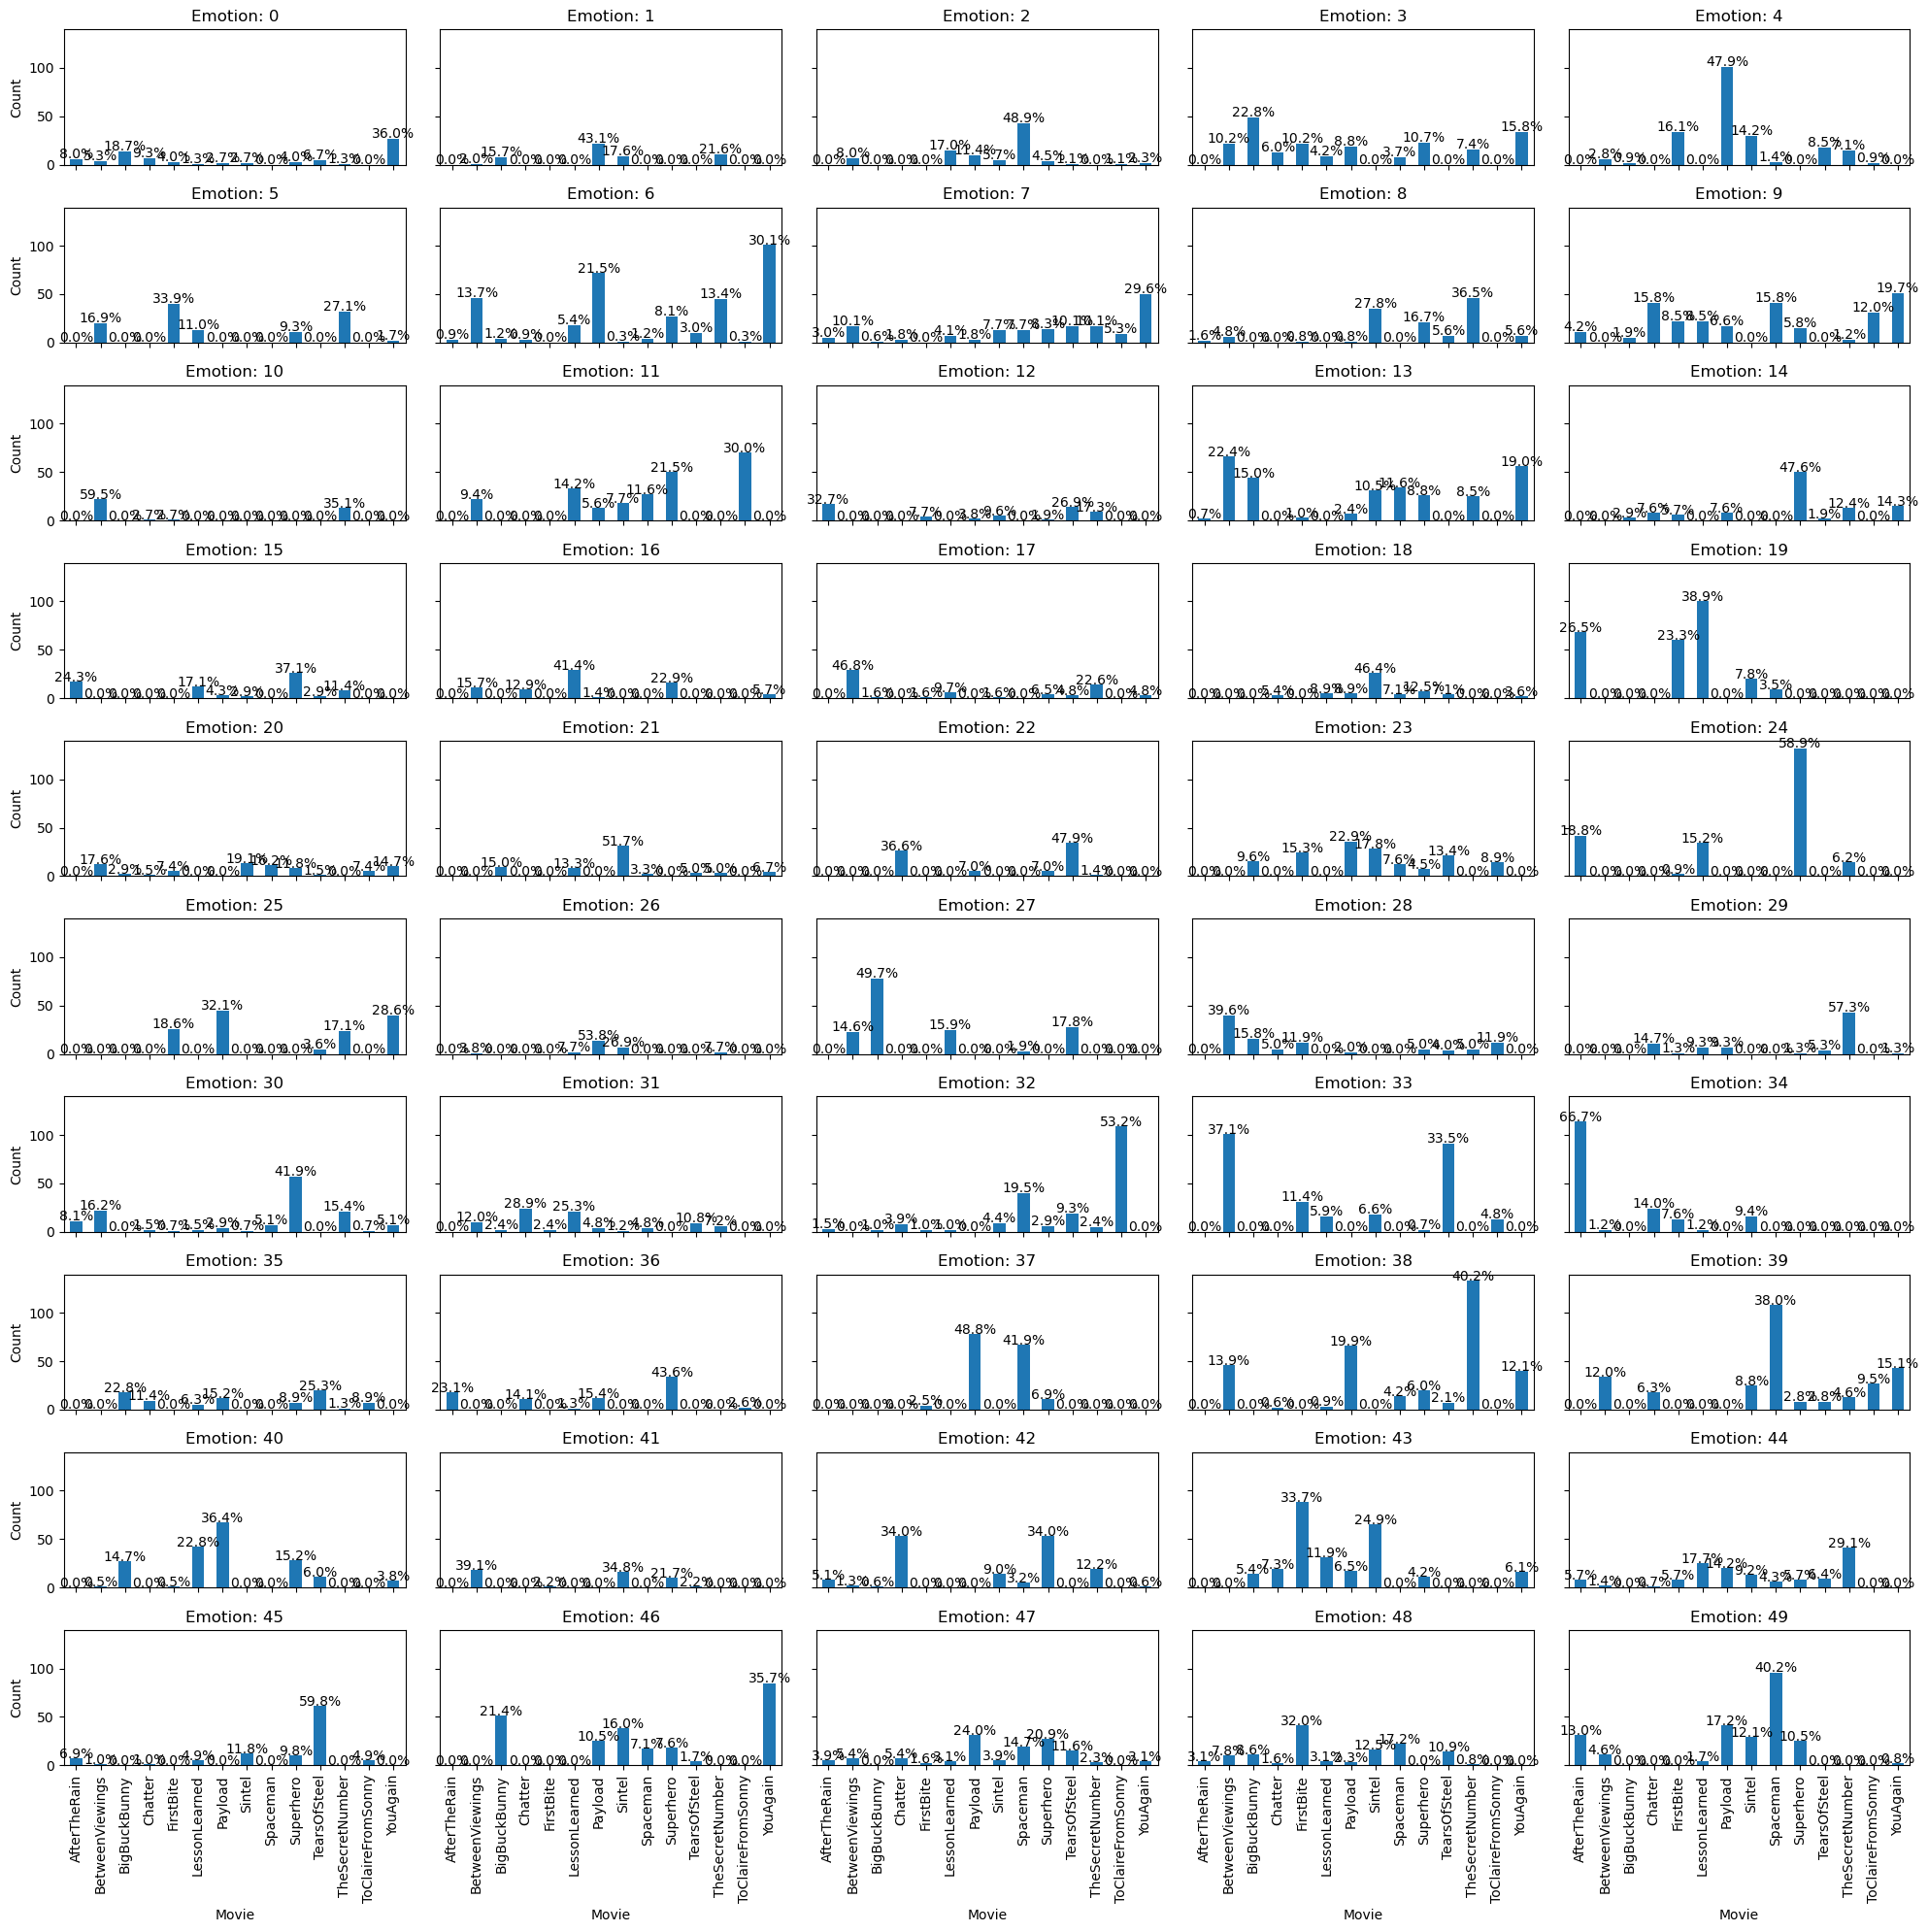

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming labels_df is your DataFrame
# Group by "movie" and "single_label", then count occurrences
grouped = labels_df.groupby(["movie", "single_label"]).size().unstack(fill_value=0)

# Define the number of rows and columns for subplots
n_rows = 10
n_cols = 5

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=True, sharey=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each label and create a plot in the corresponding subplot
for idx, label in enumerate(grouped.columns):
    ax = axes[idx]
    
    # Plot the bar chart for the current label
    grouped[label].plot(kind="bar", ax=ax, title=f"Emotion: {label}", legend=False)
    
    # Add percentages above each bar
    for p in ax.patches:
        height = p.get_height()
        total = sum(p.get_height() for p in ax.patches if p.get_x() == p.get_x())  # total height for this x position
        percentage = (height / total) * 100
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{percentage:.1f}%', ha='center')

    ax.set_ylabel('Count')
    ax.set_xlabel('Movie')

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


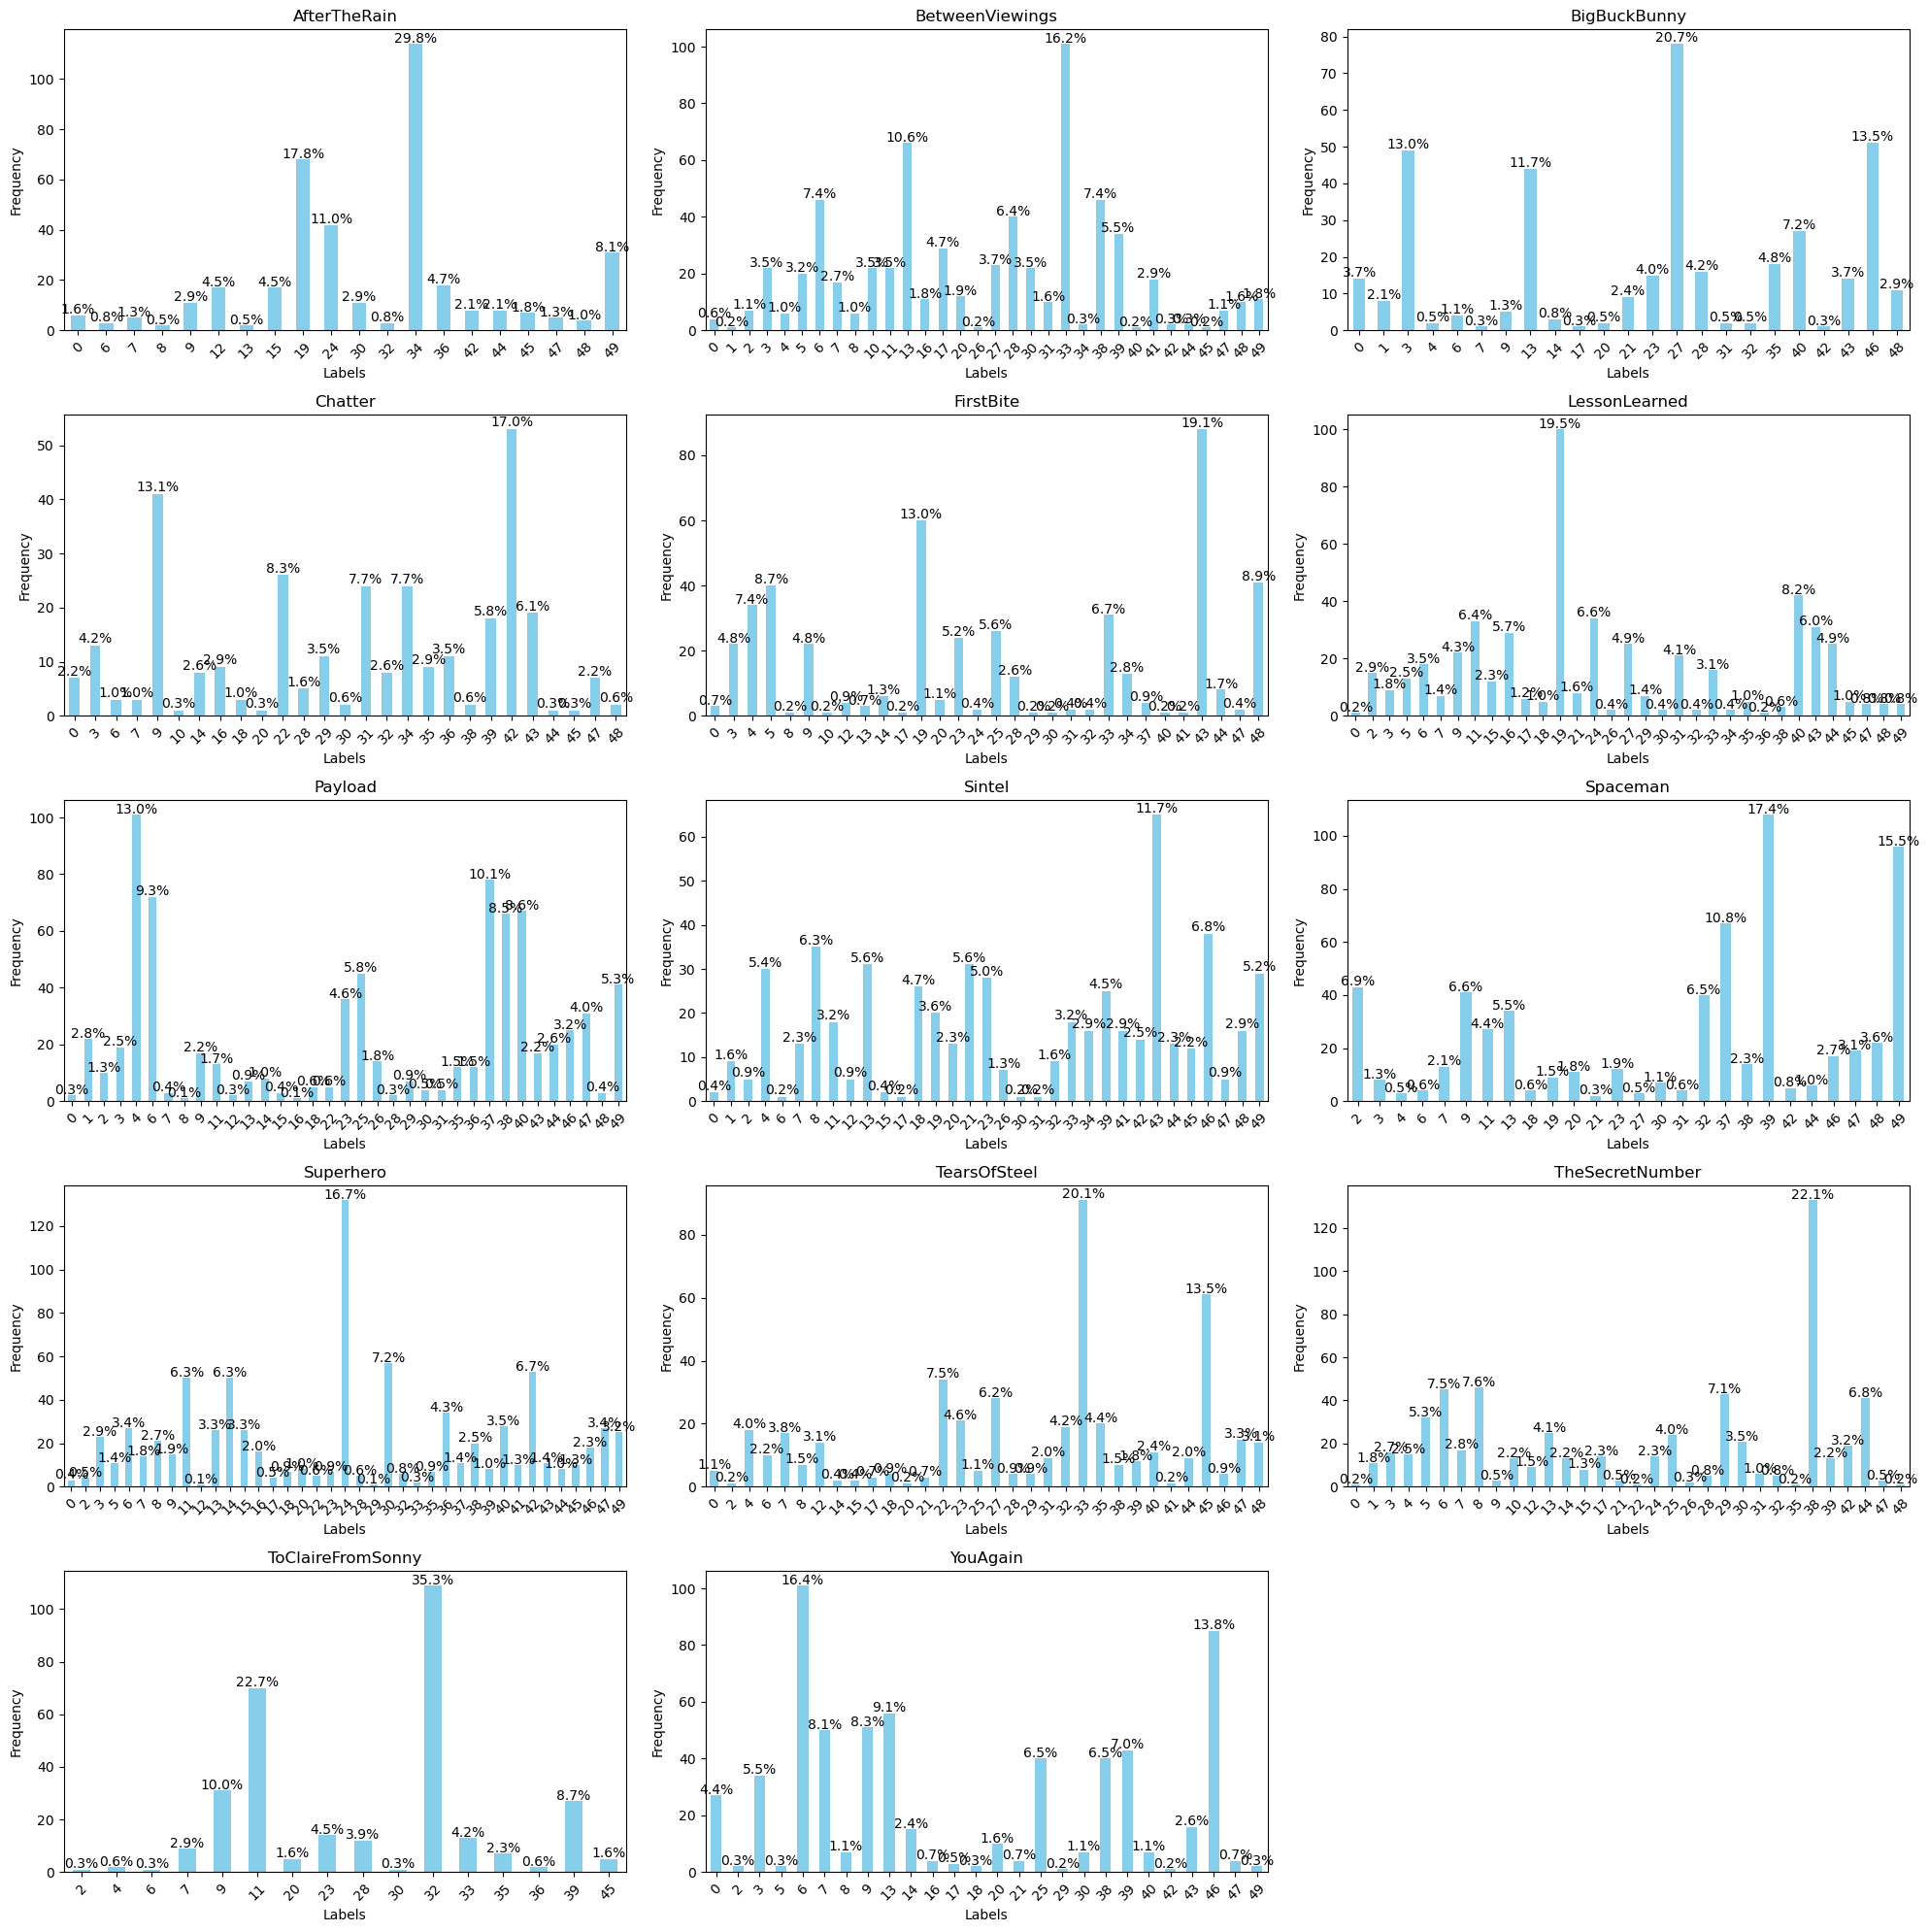

In [68]:
label_counts = labels_df.groupby(["movie", "single_label"]).size().reset_index(name="count")

# Define the number of rows and columns for subplots
n_rows = 5
n_cols = 3

# Create a figure with a 7x2 grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))#, sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Iterate over each unique movie and create a subplot for each
for idx, movie in enumerate(label_counts['movie'].unique()):
    # Filter data for the current movie
    movie_data = label_counts[label_counts['movie'] == movie]
    
    # Get the corresponding subplot axis
    ax = axes[idx]
    
    # Plot a bar chart for the current movie's label distribution
    movie_data.plot(kind="bar", x="single_label", y="count", legend=False, ax=ax, color='skyblue')
    
    # Set title and labels for each subplot
    ax.set_title(f"{movie}")
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Labels")
    ax.set_xticklabels(movie_data["single_label"], rotation=45)
    
    # Add percentages above each bar
    total = movie_data["count"].sum()
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total) * 100
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{percentage:.1f}%', ha='center')

# Hide any unused subplots if there are fewer than 14 movies
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to avoid overlapping labels
plt.tight_layout()
plt.show()

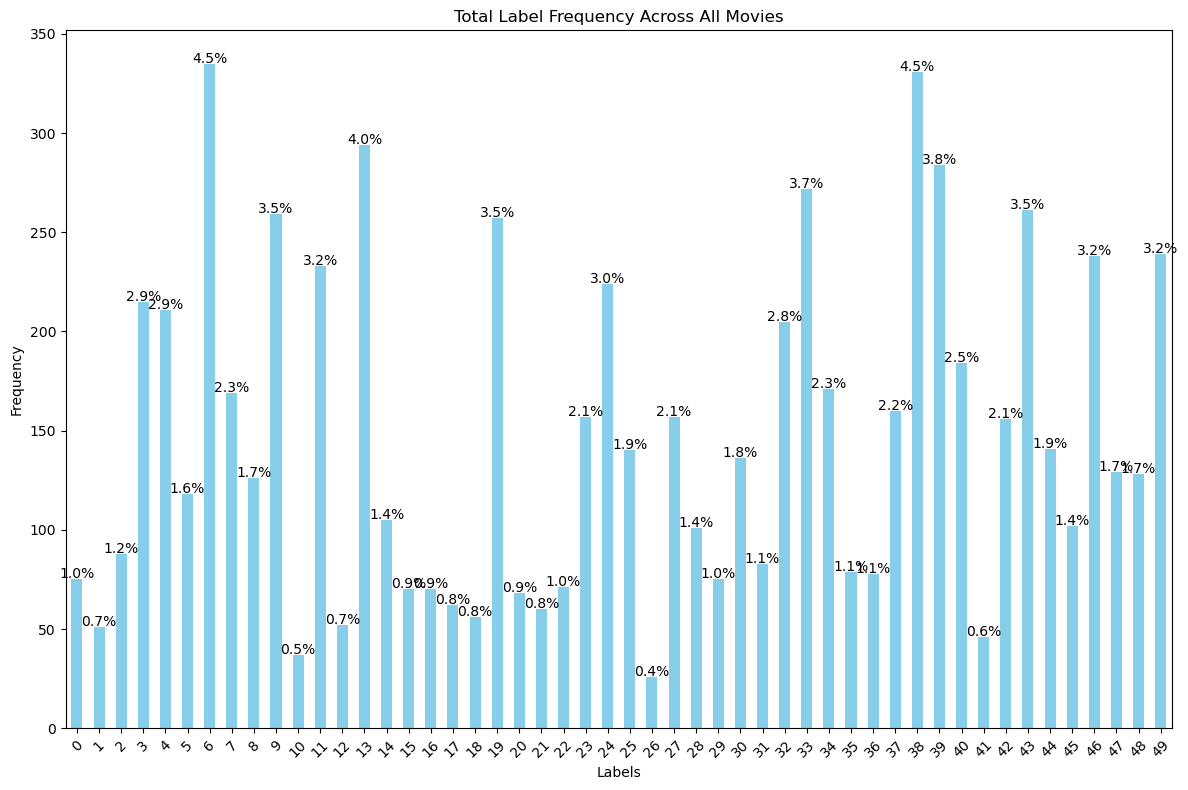

In [51]:
label_totals = labels_df.groupby("single_label").size().reset_index(name="count")

# Create a bar plot showing the frequency of each label across all movies
plt.figure(figsize=(12, 8))
ax = label_totals.plot(kind="bar", x="single_label", y="count", legend=False, color='skyblue', ax=plt.gca())

# Add title and labels
ax.set_title("Total Label Frequency Across All Movies")
ax.set_ylabel("Frequency")
ax.set_xlabel("Labels")

# Add percentages above each bar
total = label_totals["count"].sum()
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{percentage:.1f}%', ha='center')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

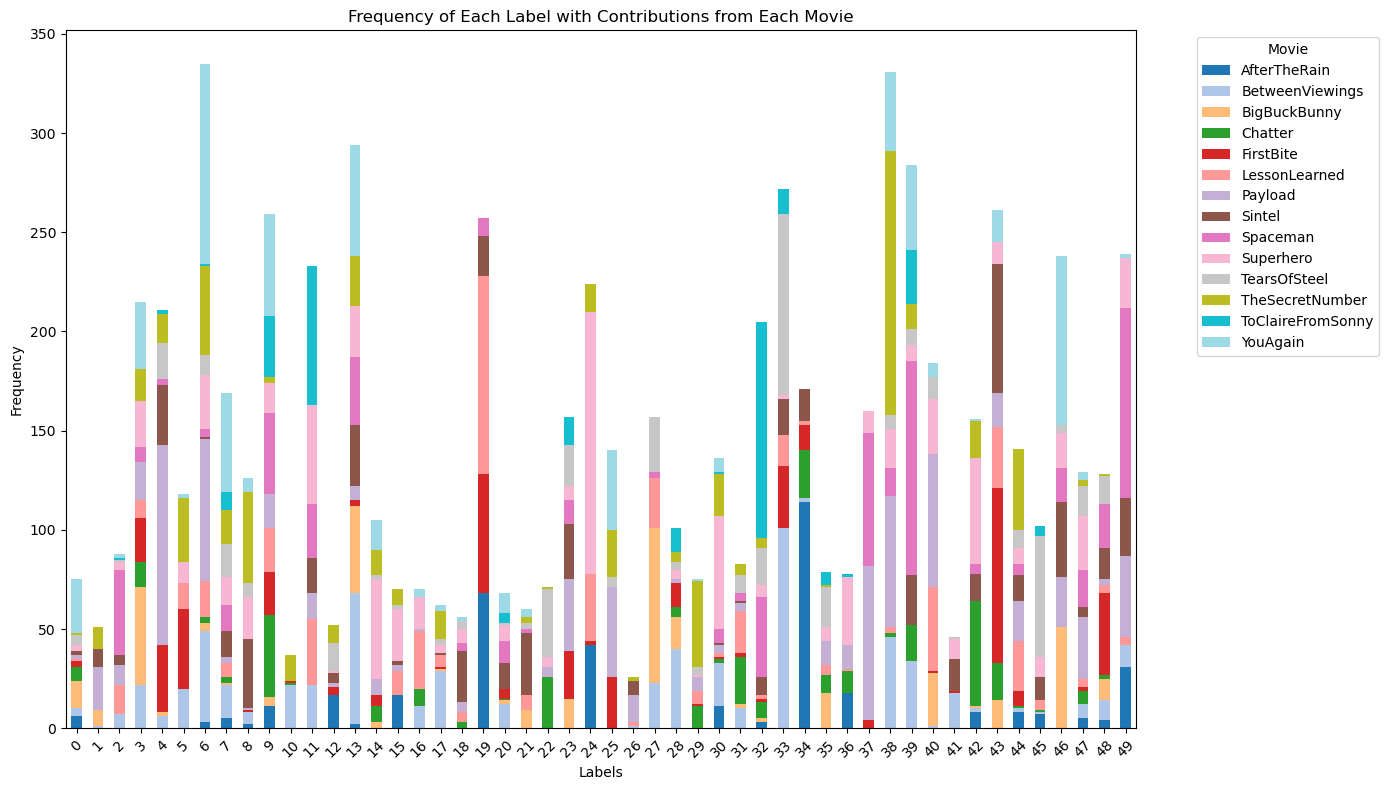

In [52]:
label_counts = labels_df.groupby(["single_label", "movie"]).size().unstack(fill_value=0)

# Plot a stacked bar chart
plt.figure(figsize=(14, 8))
ax = label_counts.plot(kind="bar", stacked=True, ax=plt.gca(), colormap="tab20")

# Set title and labels
ax.set_title("Frequency of Each Label with Contributions from Each Movie")
ax.set_ylabel("Frequency")
ax.set_xlabel("Labels")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add a legend to indicate movie contributions
plt.legend(title="Movie", bbox_to_anchor=(1.05, 1), loc="upper left")

# Display the plot
plt.tight_layout()
plt.show()

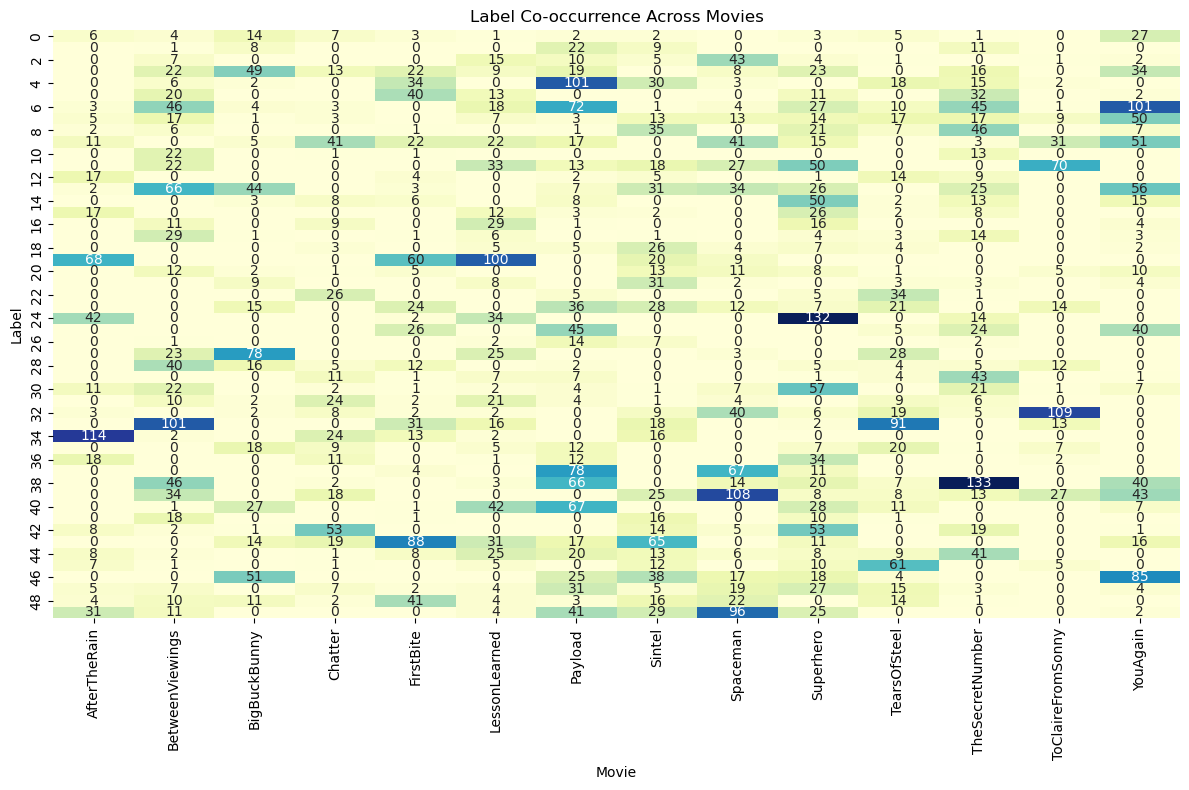

In [54]:
import seaborn as sns

# Create a pivot table of labels vs. movies
label_movie_matrix = labels_df.groupby(['single_label', 'movie']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(label_movie_matrix, cmap='YlGnBu', annot=True, fmt='d', cbar=False)
plt.title('Label Co-occurrence Across Movies')
plt.ylabel('Label')
plt.xlabel('Movie')
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd
import numpy as np

# Assuming labels_df is your DataFrame with columns "movie" and "single_label"

# Calculate label counts for each movie
label_counts = labels_df.groupby(['movie', 'single_label']).size().unstack(fill_value=0)

# Function to calculate entropy
def calculate_entropy(label_counts):
    # Normalize the label counts to probabilities
    prob = label_counts / label_counts.sum()
    
    # Calculate entropy: H(X) = - sum(p(x) * log(p(x)))
    entropy = -np.sum(prob * np.log(prob + 1e-9))  # Add small constant to avoid log(0)
    
    return entropy

# Calculate entropy for each movie
movie_entropy = label_counts.apply(calculate_entropy, axis=1)

# Sort movies by entropy (ascending: low entropy = homogeneous labels)
sorted_entropy = movie_entropy.sort_values()

# Show movies with the most homogeneous labels (lowest entropy)
print("Movies with most homogeneous labels:")
print(sorted_entropy.sort_values())


Movies with most homogeneous labels:
movie
ToClaireFromSonny    1.990409
AfterTheRain         2.332736
BigBuckBunny         2.529962
YouAgain             2.665319
FirstBite            2.695998
Spaceman             2.731771
Chatter              2.806575
TearsOfSteel         2.907002
TheSecretNumber      2.907175
BetweenViewings      2.974277
LessonLearned        2.977194
Payload              3.001449
Sintel               3.167588
Superhero            3.201528
dtype: float64


In [101]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import entropy

# Assuming labels_df is your dataframe with "movie" and "single_label"
# Get a list of unique movies
movies = labels_df['movie'].unique()

# Create a list to store combinations and their corresponding label distributions
combinations_info = []

# Generate all combinations of three movies
n_in_test = 3
movie_combinations = combinations(movies, n_in_test)

# For each combination of three movies
for combo in movie_combinations:
    # Filter the data for the current combination of movies
    combo_data = labels_df[labels_df['movie'].isin(combo)]
    
    # Calculate the frequency of each label in the combination of movies
    label_counts = combo_data['single_label'].value_counts(normalize=True)
    
    # Calculate the entropy of the label distribution
    label_entropy = entropy(label_counts, base=2)  # Using base 2 for entropy in bits
    
    # Store the combination and its entropy value
    combinations_info.append((combo, label_entropy, label_counts))

# Convert the combinations info into a DataFrame
combo_df = pd.DataFrame(combinations_info, columns=["Combination", "Entropy", "Label Frequencies"])

# Sort the combinations by entropy (lower entropy means more homogeneous distribution)
sorted_combos = combo_df.sort_values(by="Entropy").reset_index(drop=True)

# Get the combination with the most homogeneous label distribution
best_combo = sorted_combos.iloc[-1]
print("Best combination of movies with the most homogeneous label distribution (highest entropy):")
print(best_combo)


Best combination of movies with the most homogeneous label distribution (highest entropy):
Combination                          (Sintel, TearsOfSteel, Superhero)
Entropy                                                       5.262081
Label Frequencies    single_label
24    0.073415
33    0.061735
45 ...
Name: 363, dtype: object


In [105]:
movie_names = labels_df.movie.unique().tolist()
movie_names

['ToClaireFromSonny',
 'Sintel',
 'YouAgain',
 'Spaceman',
 'Payload',
 'TearsOfSteel',
 'Chatter',
 'TheSecretNumber',
 'LessonLearned',
 'BigBuckBunny',
 'AfterTheRain',
 'Superhero',
 'FirstBite',
 'BetweenViewings']

Percentage of labels in train set: 75.65% --> 5587
Percentage of labels in test set: 24.35 --> 1798


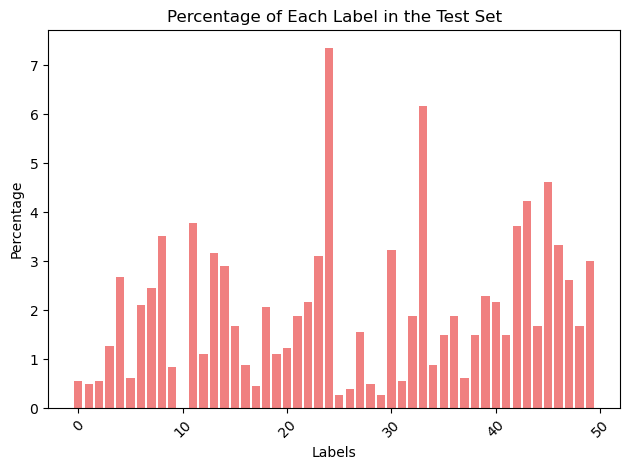

In [118]:
# with cv
#test_movies = ["Sintel", 'Payload', 'YouAgain']
test_movies = ["Sintel", "TearsOfSteel", "Superhero"]
#test_movies = ["Sintel", "LessonLearned", "AfterTheRain"]

train_movies = [movie for movie in movie_names if movie not in test_movies]


train_df = labels_df[labels_df['movie'].isin(train_movies)]
test_df = labels_df[labels_df['movie'].isin(test_movies)]

# Calculate the total number of labels in train and test sets
total_train_labels = train_df.shape[0]
total_test_labels = test_df.shape[0]

# Calculate percentage of total labels in train and test
train_percentage = (total_train_labels / (total_train_labels + total_test_labels)) * 100
test_percentage = (total_test_labels / (total_train_labels + total_test_labels)) * 100

# Print the percentages for train and test sets
print(f"Percentage of labels in train set: {train_percentage:.2f}% --> {total_train_labels}")
print(f"Percentage of labels in test set: {test_percentage:.2f} --> {total_test_labels}")

# Calculate and print the percentage of each label in the test set
label_counts_test = test_df['single_label'].value_counts(normalize=True) * 100
#print("\nPercentage of each label in the test set:")
#print(label_counts_test)

label_counts_test = test_df['single_label'].value_counts(normalize=True) * 100

# Create a simple bar plot for the percentage of each label in the test set
plt.bar(label_counts_test.index, label_counts_test.values, color='lightcoral')

# Add title and labels
plt.title("Percentage of Each Label in the Test Set")
plt.xlabel("Labels")
plt.ylabel("Percentage")
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

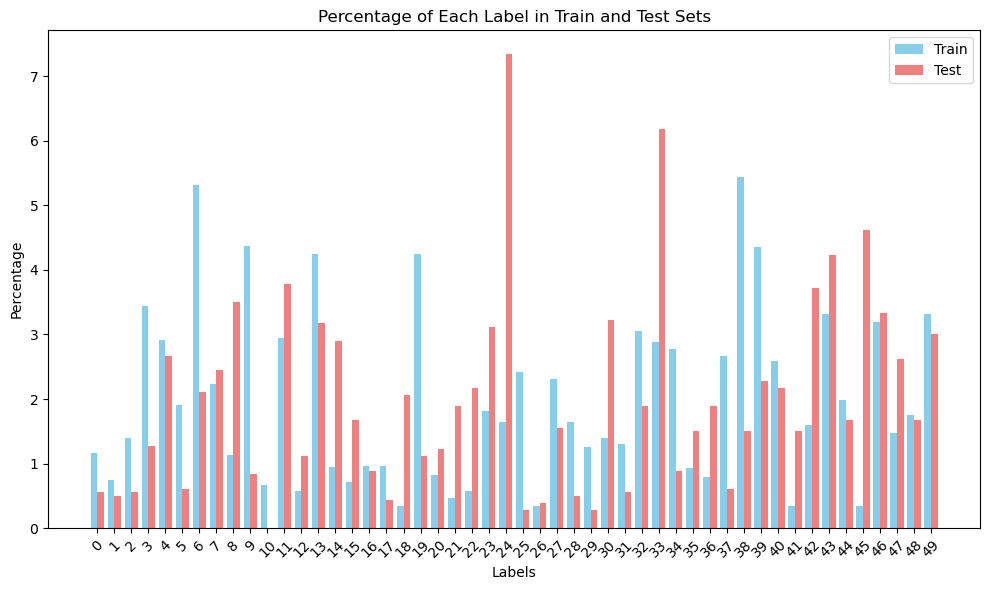

In [119]:
# Filter the dataset to create train and test sets
train_df = labels_df[labels_df['movie'].isin(train_movies)]
test_df = labels_df[labels_df['movie'].isin(test_movies)]

# Calculate percentage of each label in the train and test sets
train_label_counts = train_df['single_label'].value_counts(normalize=True) * 100
test_label_counts = test_df['single_label'].value_counts(normalize=True) * 100

# Get the labels present in both train and test sets
all_labels = set(train_label_counts.index).union(set(test_label_counts.index))

# Ensure all labels are represented in both sets (if absent, assign 0%)
train_label_counts = train_label_counts.reindex(all_labels)#, fillvalue=0)
test_label_counts = test_label_counts.reindex(all_labels)#, fillvalue=0)

# Create a bar plot with two bars side by side for each label
x = range(len(all_labels))

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for train and test sets side by side
width = 0.4  # Bar width
ax.bar([i - width/2 for i in x], train_label_counts, width=width, label='Train', color='skyblue')
ax.bar([i + width/2 for i in x], test_label_counts, width=width, label='Test', color='lightcoral')

# Add title and labels
ax.set_title("Percentage of Each Label in Train and Test Sets")
ax.set_xlabel("Labels")
ax.set_ylabel("Percentage")
ax.set_xticks(x)
ax.set_xticklabels(all_labels, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Load delay file

In [6]:
# Load onset of different movies, for differt subejcts
with open("data/raw/labels/run_onsets.pkl", "rb") as file:
    delta_time = pkl.load(file)

delta_time.keys()

dict_keys(['TheSecretNumber', 'ToClaireFromSonny', 'Chatter', 'LessonLearned', 'Payload', 'AfterTheRain', 'Superhero', 'Sintel', 'TearsOfSteel', 'BetweenViewings', 'BigBuckBunny', 'YouAgain', 'Spaceman', 'FirstBite'])

# Add Column with Labels to movie df

In [7]:
dir_path = "data/raw/movies"
tr_len = 1.3
delay_hrf = 4 #tr
subjects = [f"{i:02d}" for i in range(1, 31)] # hoping every sub has seen every movie
col_label = "single_label" #type of label to use from df_labels

# list odf dfs with, each one is a movie
dfs_movies = []

for i, file in enumerate(sorted(os.listdir(dir_path))):

    # read csv
    print(f"Creating {file}...")
    file_path = os.path.join(dir_path, file)
    df_movie = pd.read_csv(file_path)

    #add info of the movie
    movie = re.match(r"^([a-zA-Z]+)_compiled\d+\.csv$", file).group(1)
    df_movie["movie_str"] = movie
    df_movie["movie"] = i

    # add timestamp
    df_movie["timestamp_tr"] = df_movie.groupby(["movie_str", "id", "vindex"]).cumcount() #Number each item in each group from 0 to the length of that group - 1.
    df_movie["timestamp_sec"] = df_movie["timestamp_tr"] * tr_len

    # in case for some movies only a subset of subs has seen it
    subjects = df_movie["id"].sort_values().unique()
    subjects = [re.search(r'sub-S(\d+)', id).group(1) for id in subjects if re.search(r'sub-S(\d+)', id)]

    #df with the labels of THIS movie (in TR)
    labels_movie_df = labels_df.loc[labels_df["movie"] == movie, [col_label]]

    # Contains all the df of differt sub of same movie
    dfs_movies_subjects = []


    for sub in subjects:
        print(f"\tAligning subject {sub} for movie {movie}...")

        # put all elemnt of this movie and subjct to -1 (show that we passed here, but still not yet a real label)
        df_movie_sub = df_movie[(df_movie["id"] == f"sub-S{sub}") & (df_movie["movie_str"] == movie)]

        # Ectarct timeshift and duration fir thius sub and this movie
        delta_time_single = delta_time[movie][f"S{sub}"]
        start_movie_sec = delta_time_single[0]
        lenght_movie_sec = delta_time_single[1]
        start_movie_tr = int(start_movie_sec / tr_len)
        lenght_movie_tr = int(lenght_movie_sec / tr_len)
        #print(f"Movie shown at {start_movie_sec} sec. Duration of the movie {lenght_movie_sec} sec.")

        # make the TR index be the same of when the movie begin (NB different for each sub)
        labels_movie_df_copy = labels_movie_df.copy()
        labels_movie_df_copy["timestamp_tr"] = [i for i in range(labels_movie_df.shape[0])] # create  anew col form 0 to len movie  in tr
        labels_movie_df_copy["timestamp_tr"] = labels_movie_df_copy["timestamp_tr"] + start_movie_tr # shift when the movie start
        labels_movie_df_copy["timestamp_tr"] = labels_movie_df_copy["timestamp_tr"] + delay_hrf #shift after for fue to HRF

        df_movie_sub = pd.merge(left = df_movie_sub,
                                right = labels_movie_df_copy,
                                on = "timestamp_tr",
                                how= "left", #A "left" merge means that all rows from df_movie_sub will be retained in the resulting DataFrame, even if there is no matching timestamp_tr in labels_movie_df.
                                ).fillna(-1)  # This fills any NaN values in the result with -1 (remian TR without label)

        #display(df_movie_sub)

        # make id to be int
        df_movie_sub["id"] = int(sub)

        dfs_movies_subjects.append(df_movie_sub)

    movie_df = pd.concat(dfs_movies_subjects, ignore_index=True)

    #display(movie_df[movie_df.full_region == "7Networks_LH_Vis_1"]) #to show only one region and see if the labesl are coreect

    dfs_movies.append(movie_df)

movies_df = pd.concat(dfs_movies, ignore_index=True)

display(movies_df)

# Save mapping mvoies --> int
df_mapping = movies_df[["movie", "movie_str"]].copy()
df_mapping = df_mapping.drop_duplicates()
df_mapping.to_csv('data/raw/labels/category_mapping_movies.csv', index=False)

Creating AfterTheRain_compiled414.csv...
	Aligning subject 01 for movie AfterTheRain...
	Aligning subject 02 for movie AfterTheRain...
	Aligning subject 03 for movie AfterTheRain...
	Aligning subject 04 for movie AfterTheRain...
	Aligning subject 05 for movie AfterTheRain...
	Aligning subject 06 for movie AfterTheRain...
	Aligning subject 07 for movie AfterTheRain...
	Aligning subject 08 for movie AfterTheRain...
	Aligning subject 09 for movie AfterTheRain...
	Aligning subject 10 for movie AfterTheRain...
	Aligning subject 11 for movie AfterTheRain...
	Aligning subject 13 for movie AfterTheRain...
	Aligning subject 14 for movie AfterTheRain...
	Aligning subject 15 for movie AfterTheRain...
	Aligning subject 16 for movie AfterTheRain...
	Aligning subject 17 for movie AfterTheRain...
	Aligning subject 19 for movie AfterTheRain...
	Aligning subject 20 for movie AfterTheRain...
	Aligning subject 21 for movie AfterTheRain...
	Aligning subject 22 for movie AfterTheRain...
	Aligning subject 2

,filename,vindex,full_region,partial_region,score,movie_name,parcel,id,session,movie_str,movie,timestamp_tr,timestamp_sec,single_label
0,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-21.180140,AfterTheRain,400,1,ses-1,AfterTheRain,0,0,0.0,-1
1,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-14.295689,AfterTheRain,400,1,ses-1,AfterTheRain,0,1,1.3,-1
2,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,-5.882564,AfterTheRain,400,1,ses-1,AfterTheRain,0,2,2.6,-1
3,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,30.127113,AfterTheRain,400,1,ses-1,AfterTheRain,0,3,3.9,-1
4,TC_414_sub-S01_AfterTheRain.csv,0,7Networks_LH_Vis_1,Vis,41.830845,AfterTheRain,400,1,ses-1,AfterTheRain,0,4,5.2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118876369,TC_414_sub-S32_YouAgain.csv,413,Right Accumbens,Sub,-21.945122,YouAgain,14,32,ses-1,YouAgain,13,763,991.9,-1
118876370,TC_414_sub-S32_YouAgain.csv,413,Right Accumbens,Sub,3.040432,YouAgain,14,32,ses-1,YouAgain,13,764,993.2,-1
118876371,TC_414_sub-S32_YouAgain.csv,413,Right Accumbens,Sub,-36.525375,YouAgain,14,32,ses-1,YouAgain,13,765,994.5,-1
118876372,TC_414_sub-S32_YouAgain.csv,413,Right Accumbens,Sub,-7.233601,YouAgain,14,32,ses-1,YouAgain,13,766,995.8,-1


In [8]:
# save memory

movies_df_small = movies_df.copy()

# call the col_label as "label"
movies_df_small = movies_df_small.rename(columns = {col_label : "label"})

# remvoe useless cols<
# only retain columsn for claucltation, then for intepretation we can always do some merge
movies_df_small = movies_df_small.drop(columns=["filename", "parcel" , "session", "timestamp_sec", "movie_name", "full_region", "partial_region", "movie_str"]).copy()

# Spefici type columns to save mepory
movies_df_small['movie'] = movies_df_small['movie'].astype('int8')
movies_df_small['label'] = movies_df_small['label'].astype('int8')
movies_df_small['vindex'] = movies_df_small['vindex'].astype('int16')
movies_df_small['id'] = movies_df_small['id'].astype('int8')  # Convert to category if the values are repetitive
movies_df_small['timestamp_tr'] = movies_df_small['timestamp_tr'].astype('int16')
movies_df_small['score'] = movies_df_small['score'].astype('float32')

movies_df_small

,vindex,score,id,movie,timestamp_tr,label
0,0,-21.180140,1,0,0,-1
1,0,-14.295689,1,0,1,-1
2,0,-5.882564,1,0,2,-1
3,0,30.127113,1,0,3,-1
4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...
118876369,413,-21.945122,32,13,763,-1
118876370,413,3.040432,32,13,764,-1
118876371,413,-36.525375,32,13,765,-1
118876372,413,-7.233601,32,13,766,-1


In [9]:
# Check meory usage

memory_usage_bytes = movies_df_small.memory_usage(deep=True).sum()
memory_usage_gb = memory_usage_bytes / (1024**3)

print(f"Memory usage: {memory_usage_gb:.4f} GB")


Memory usage: 1.2178 GB


In [10]:
# Save df
movies_df_small.to_csv("data/processed/all_movies_labelled.csv")
#movies_df.to_csv('movies_data.csv.zst', index=False, compression='zstd')


In [11]:
# tru to load

movies_df_loaded = pd.read_csv("data/processed/all_movies_labelled.csv")


# Tests and Checks

In [12]:
movies_df_loaded

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
118876369,118876369,413,-21.945122,32,13,763,-1
118876370,118876370,413,3.040432,32,13,764,-1
118876371,118876371,413,-36.525375,32,13,765,-1
118876372,118876372,413,-7.233601,32,13,766,-1


In [13]:
# let's use after the rain for tets
afterrain = movies_df_loaded[movies_df_loaded.movie == 0]
afterrain

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
6691063,6691063,413,-18.636782,32,0,532,-1
6691064,6691064,413,-53.956333,32,0,533,-1
6691065,6691065,413,-59.845350,32,0,534,-1
6691066,6691066,413,-34.693714,32,0,535,-1


In [14]:
# for a SINGLE TIMEPOINT AND SINGLE SUB the ows hsud eb equal tot th numebr of nodes --> 414
afterrain[(afterrain.timestamp_tr == 0) & (afterrain.id == 1)]

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
534,534,1,-26.000616,1,0,0,-1
1068,1068,2,-75.883064,1,0,0,-1
1602,1602,3,-49.927452,1,0,0,-1
2136,2136,4,-81.747790,1,0,0,-1
...,...,...,...,...,...,...,...
218406,218406,409,-5.679001,1,0,0,-1
218940,218940,410,19.796326,1,0,0,-1
219474,219474,411,-98.217730,1,0,0,-1
220008,220008,412,-54.685820,1,0,0,-1


In [15]:
# for a SINGLE SUB AND SINGLE NODE thE number of timepsoint shodul be the durian of the fmrin in TR
afterrain[(afterrain.vindex == 0) & (afterrain.id == 1)]

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
529,529,0,12.306594,1,0,529,-1
530,530,0,-24.227661,1,0,530,-1
531,531,0,-29.801235,1,0,531,-1
532,532,0,-13.306865,1,0,532,-1


In [16]:
# for a SINGLE SUB AND SINGLE NODE 
# check
    # the TR when the mvoie starts (ie labels != -1)
    # how loin is the duration of the movie (ie TR labelleed)  
afterrain[(afterrain.vindex == 0) & (afterrain.id == 1) & (afterrain.label != -1)]

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
61,61,0,-2.733954,1,0,61,6
62,62,0,-46.140920,1,0,62,6
63,63,0,-5.872955,1,0,63,6
64,64,0,-26.328144,1,0,64,44
65,65,0,-24.370848,1,0,65,44
...,...,...,...,...,...,...,...
438,438,0,-41.126038,1,0,438,49
439,439,0,-15.191757,1,0,439,49
440,440,0,8.831560,1,0,440,49
441,441,0,11.668606,1,0,441,49


In [17]:
# cehck if order of labels is correct
labels_df.loc[labels_df['movie'] == "AfterTheRain", col_label]

5129     6
5130     6
5131     6
5132    44
5133    44
        ..
5506    49
5507    49
5508    49
5509    49
5510    49
Name: single_label, Length: 382, dtype: object

# Test Create dataset

In [ ]:
from scripts.utils import *

In [18]:
df_all_movies = pd.read_csv("data/processed/all_movies_labelled.csv")

In [28]:
df_rain = df_all_movies[df_all_movies.movie  == 0]
display(df_rain)
dataset = DatasetEmo(df=df_rain)
graphs_list = dataset.get_graphs_list()

,Unnamed: 0,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1
...,...,...,...,...,...,...,...
6691063,6691063,413,-18.636782,32,0,532,-1
6691064,6691064,413,-53.956333,32,0,533,-1
6691065,6691065,413,-59.845350,32,0,534,-1
6691066,6691066,413,-34.693714,32,0,535,-1


Creating the graph 0 1 0/382
Creating the graph 0 1 1/382
Creating the graph 0 1 2/382
Creating the graph 0 1 3/382
Creating the graph 0 1 4/382
Creating the graph 0 1 5/382
Creating the graph 0 1 6/382
Creating the graph 0 1 7/382
Creating the graph 0 1 8/382
Creating the graph 0 1 9/382
Creating the graph 0 1 10/382
Creating the graph 0 1 11/382
Creating the graph 0 1 12/382
Creating the graph 0 1 13/382
Creating the graph 0 1 14/382
Creating the graph 0 1 15/382
Creating the graph 0 1 16/382
Creating the graph 0 1 17/382
Creating the graph 0 1 18/382
Creating the graph 0 1 19/382
Creating the graph 0 1 20/382
Creating the graph 0 1 21/382
Creating the graph 0 1 22/382
Creating the graph 0 1 23/382
Creating the graph 0 1 24/382
Creating the graph 0 1 25/382
Creating the graph 0 1 26/382
Creating the graph 0 1 27/382
Creating the graph 0 1 28/382
Creating the graph 0 1 29/382
Creating the graph 0 1 30/382
Creating the graph 0 1 31/382
Creating the graph 0 1 32/382
Creating the graph 0

In [ ]:
print(graphs_list[0])
loader = pyg.loader.DataLoader(graphs_list, batch_size=32, num_workers=4, persistent_workers=True)

first_batch = next(iter(loader))
print(first_batch)
# Attention
    # when you batch multiple graphs, the node features and edge indices of the individual graphs are concatenated into a single large batch
    #batch=[13248]: This is a batch vector that indicates to which graph each node belongs. 
    #The ptr tensor helps define the boundaries of each graph. For example, if ptr[i] = 10 and ptr[i+1] = 20, that means the nodes from index 10 to 19 belong to the i-th graph

Data(x=[414, 1], edge_index=[2, 170982], edge_attr=[170982, 1], y=6)
DataBatch(x=[13248, 1], edge_index=[2, 5471424], edge_attr=[5471424, 1], y=[32], batch=[13248], ptr=[33])
